Imports

In [4]:
import pandas as pd
import plotly as pl
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import AffinityPropagation, DBSCAN, Birch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import sklearn as sk
import numpy as np
import math
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
DATA = pd.read_csv("online_shoppers_intention.csv")


===Task 1: Get data on screen===

Goal: Make visualizations that help understand the data

                    Feature Data Type
0            Administrative     int64
1   Administrative_Duration   float64
2             Informational     int64
3    Informational_Duration   float64
4            ProductRelated     int64
5   ProductRelated_Duration   float64
6               BounceRates   float64
7                 ExitRates   float64
8                PageValues   float64
9                SpecialDay   float64
10                    Month    object
11         OperatingSystems     int64
12                  Browser     int64
13                   Region     int64
14              TrafficType     int64
15              VisitorType    object
16                  Weekend      bool
17                  Revenue      bool


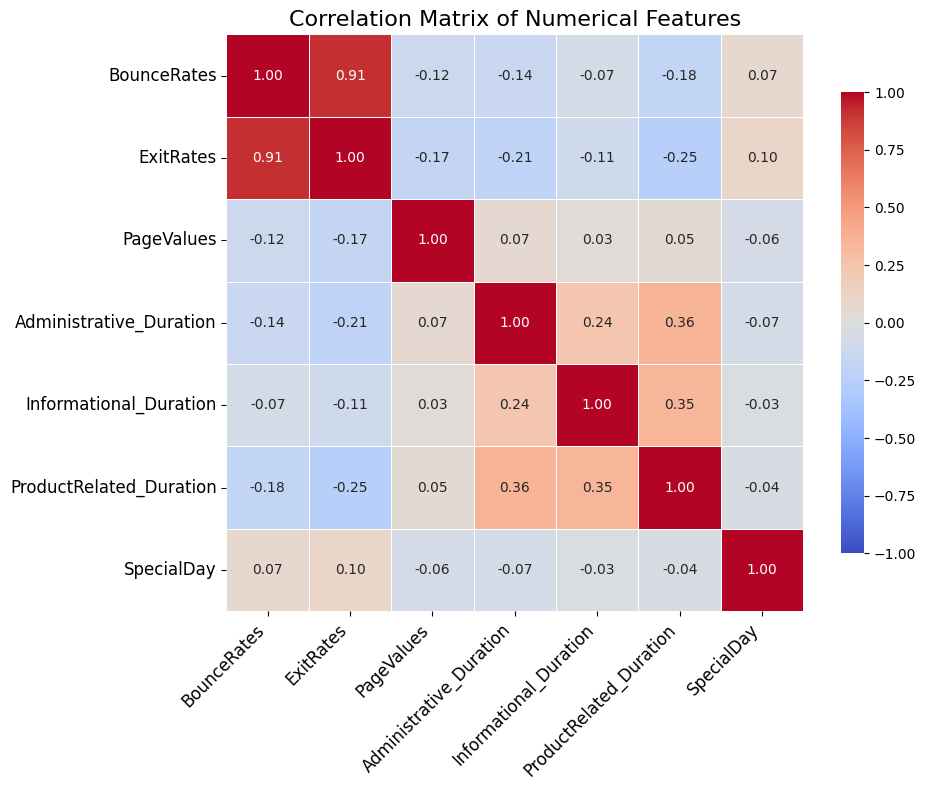

NameError: name 'table' is not defined

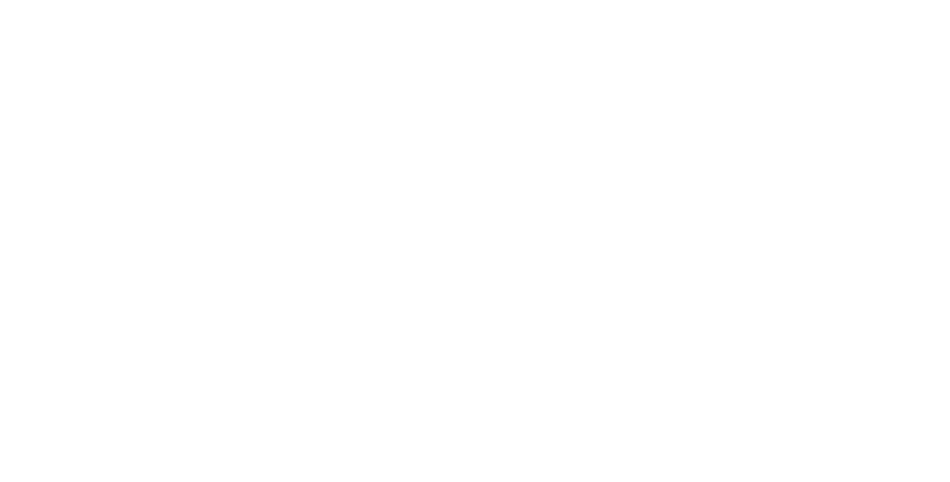

In [5]:
#Task 1.1
 
#Create a copy of the data and analyze the data types
DATAvis = DATA
features_data_types = DATAvis.dtypes.reset_index()
features_data_types.columns = ['Feature', 'Data Type']
 
 
print(features_data_types)
 
 
# New- vs. Returning customers pie chart
 
 
fig = px.pie(DATAvis, names='VisitorType', title='Types of Customers')
fig.update_layout(width=500)
fig.show()
 
 
 
 
# BOUNCERATES VS EXITRATES scatter plot
fig = px.scatter(DATAvis, x="BounceRates", y="ExitRates")
fig.update_layout(
    title="Bounce Rates vs Exit Rates",
    yaxis_title="Exit rates",  
    xaxis_title='Bounce Rates',
    width=500  
)
fig.show()
 
 
 
 
 
 
#Purchases per month
purchase_counts = DATAvis[DATAvis['Revenue']].groupby('Month').size().reset_index(name='Count')
 
#Visualize this
fig = px.bar(purchase_counts, x='Month', y='Count', title='Count of Purchases by Month')
fig.update_layout(
    width=700  
)
fig.show()
 
 
# PURCHASES CLOSE TO IMPORTANT DATES
SD_purchase_data = DATAvis[DATAvis['Revenue']]
 
 
SD_purchase_counts = SD_purchase_data['SpecialDay'].value_counts().reset_index()
SD_purchase_counts.columns = ['SpecialDay', 'Count']
 
 
SD_purchase_counts = SD_purchase_counts.sort_values('SpecialDay')
 
 
fig = px.line(SD_purchase_counts, x='SpecialDay', y='Count', title='Count of Purchases by Days to Special Day')
fig.update_layout(
    width=700  
)
fig.update_layout(xaxis=dict( autorange="reversed"))
 
 
fig.show()
 
# Separate numerical features for numerical visualization
numerical_features = [
    'BounceRates',
    'ExitRates',
    'PageValues',
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'SpecialDay'
]
 
#Create a subset of these features
subset_data = DATAvis[numerical_features]
 
 
correlation_matrix = subset_data.corr()
 
 
#Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8},
    linewidths=.5,
    vmin=-1,
    vmax=1  
)
 
 
# Update layout
plt.title('Correlation Matrix of Numerical Features', fontsize=16)  
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(rotation=0, fontsize=12)  
plt.tight_layout()
plt.show()
 
 
 
 
# Task 1.2
 
#Seperate data from browser 13 compared to other browsers
browser_13_data = DATAvis[DATAvis['Browser'] == 13]
other_browser_data = DATAvis[DATAvis['Browser'] != 13]
 
 
#Create new column where this data is stored
DATAvis['BrowserType'] = DATAvis['Browser'].apply(lambda x: 'Browser 13' if x == 13 else 'Other Browsers')
 
 
#Create the values for the summary of all numerical data
overall_summary = DATAvis.agg({
    'BounceRates': ['mean', 'median', 'count'],
    'ExitRates': ['mean', 'median', 'count'],
    'PageValues': ['mean', 'median', 'count'],
    'Administrative_Duration': ['mean', 'median', 'count'],
    'Informational_Duration': ['mean', 'median', 'count'],
    'ProductRelated_Duration': ['mean', 'median', 'count'],
    'SpecialDay': ['mean', 'median', 'count'],
}).T  
 
 
# Reset the index to get the feature names in a proper column
overall_summary = overall_summary.reset_index()
overall_summary.columns = ['Feature', 'Mean', 'Median', 'Count']
 
 
# Round to 5 decimals
overall_summary['Mean'] = overall_summary['Mean'].round(5)
overall_summary['Median'] = overall_summary['Median'].round(5)
 
 
# Create a plot to show the table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
 
 
# Add the table to the plot
tbl = table(ax, overall_summary, loc='center', cellLoc='center', colWidths=[0.2]*len(overall_summary.columns))
 
 
# Make column headers bold
for key, cell in tbl.get_celld().items():
    if key[0] == 0:  
        cell.set_text_props(fontweight='bold')
 
 
plt.show()
 
#Filter the data to include only these 3 features
filtered_data = overall_summary[overall_summary['Feature'].isin(['BounceRates', 'ExitRates', 'SpecialDay'])]
 
 
# Reshape data for plotting, using melt() function
mean_median_data = filtered_data.melt(id_vars='Feature', value_vars=['Mean', 'Median'], var_name='Stat', value_name='Value')
 
 
# Create a bar chart to compare mean and median
fig = px.bar(mean_median_data, x='Feature', y='Value', color='Stat', barmode='group',
             title='Comparison of Mean and Median for Bounce Rates, Exit Rates, and Special Day',
             labels={'Value': 'Value', 'Feature': 'Numerical Feature'},
             width=800)
 
 
# Set the y-axis range to deal with outliers
fig.update_layout(
    yaxis_title='Value',
    xaxis_title='Feature',
    xaxis_tickangle=-45,
    yaxis_range=[0, 0.1]  
)
 
fig.show()
 
 
#Seperate the data for browser 13 only
browser_13_data = DATAvis[DATAvis['Browser'] == 13]
browser_13_summary = browser_13_data.agg({
    'BounceRates': ['mean', 'median', 'count'],
    'ExitRates': ['mean', 'median', 'count'],
    'PageValues': ['mean', 'median', 'count'],
    'Administrative_Duration': ['mean', 'median', 'count'],
    'Informational_Duration': ['mean', 'median', 'count'],
    'ProductRelated_Duration': ['mean', 'median', 'count'],
    'SpecialDay': ['mean', 'median', 'count'],
}).reset_index()
 
 
 
 
# Create a plot to show the table
fig, ax = plt.subplots(figsize=(12, 6))  
ax.axis('tight')
ax.axis('off')
 
 
 
 
 
 
print("This is the overall summary:")
print(overall_summary)
print("This is the browser 13 summary")
print(browser_13_summary)
 
 
#Create a small dataframe to visualize difference in page values, which was most noticable from the summary
page_values_data = pd.DataFrame({
    'Browser Type': ['Overall'] + ['Browser 13'],
    'Page Values': [5.889258, 26.268249],
})
 
 
fig_page_values = px.bar(page_values_data, x='Browser Type', y='Page Values',
                         title='Mean Page Values for Overall Browsers and Browser 13',
                         width = 700,
                         color = 'Browser Type')
 
 
fig_page_values.show()
 
 
#Compare the duration metrics
fig = px.box(DATAvis, y=['Administrative_Duration', 'Informational_Duration'],
             color='BrowserType',
             title='Box Plots of Duration Metrics: Browser 13 vs Other Browsers')
 
#Set y-axis range to deal with outliers
fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    yaxis_range=[0, 500],
    width=800
)
fig.show()
 
 
fig = px.box(DATAvis, y=['ProductRelated_Duration'],
             color='BrowserType',
             title='Box Plot of Product Related Duration: Browser 13 vs Other Browsers')
 
 
fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    width=800,
    yaxis_range=[0,5000]
)
fig.show()

===Task 2: Preprocessing of the dataset===

There are no missing values in the dataset
Index(['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',

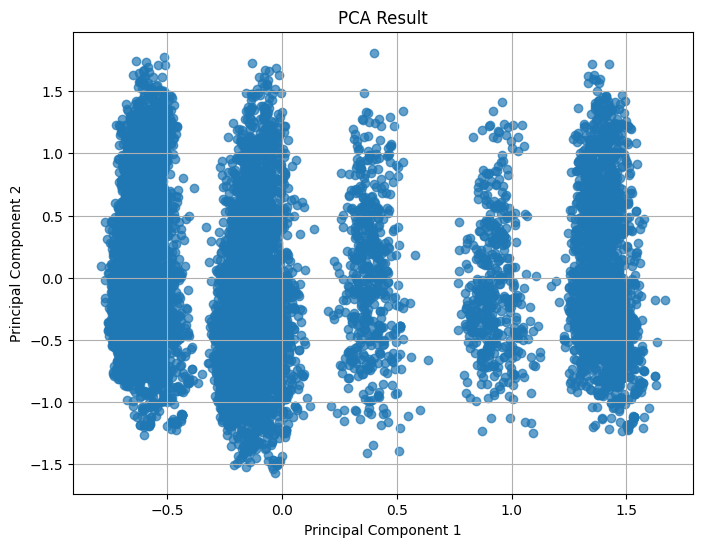

In [6]:

# cleaning
cleaneddata = DATA.dropna()
if len(DATA)-len(cleaneddata) == 0:
    print("There are no missing values in the dataset")

#candidates for one-hot-encoding (OHE)
featuresOHN = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
cleaneddata[featuresOHN] = cleaneddata[featuresOHN].astype(str)
transformer = make_column_transformer((OneHotEncoder(categories='auto', sparse_output=False), featuresOHN), remainder='passthrough')
transformed = transformer.fit_transform(DATA)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
 
# clean column names for readability
flist = df.columns.to_list()
newflist = [col.replace('remainder__', '') if col.startswith('remainder__') else col.replace('onehotencoder__', '') for col in flist]
df.columns = newflist
 
print(df.columns)

# Encoding bools to 1 and 0
boolcolumns = ['Weekend','Revenue']
for column in boolcolumns:
    cleaneddata[column] = cleaneddata[column].replace({'TRUE': 1, 'FALSE': 0})
    df[column] = df[column].replace({'TRUE': 1, 'FALSE': 0})
print(cleaneddata.columns)
 
 
encodedcolumns = ['OperatingSystems','Browser','Region','TrafficType','BrowserType']
 
dropencoded = False
for column in encodedcolumns:
    if dropencoded:
        df = df.drop(columns=[column])
 
#df = df.drop(columns=['Month','VisitorType'])
df = df.drop(columns=['BrowserType'])
 
 
# data normalization
featuresMinMax = ['BounceRates', 'ExitRates','Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']
featureslog = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']
 
 
for f in featureslog:
    df[f] = df[f].astype(float)
    df[f] = np.log1p(df[f])
 
for f in featuresMinMax:
    df[f] = (df[f] - df[f].min()) /(df[f].max() - df[f].min())
 
 
# Applying PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
pca_result = pca.fit_transform(df)
 
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
 
# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("PCA Result Head:\n", pca_df.head())
 
 
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()
 
 
 
#Take a random sample from the dataset which can be used for complexer models which do not scale well
df_sample = pca_df.sample(frac = 0.35)
df_sillhouette_sample = pca_df.sample(frac = 0.20)


===Task 3: Clustering Algorithms===

Here we aim to implement 3 different clustering algorithms and visualize their results.

Task 3.1 - Affinity Propagation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



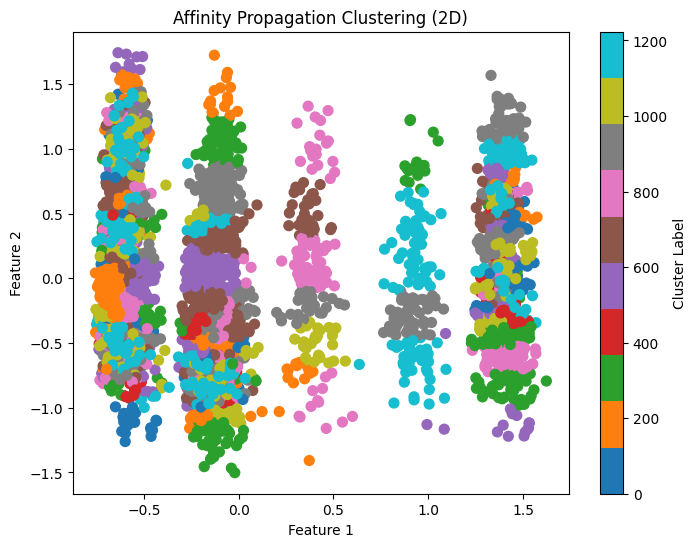

In [7]:

# Affinity Propagation, different code blocks to test each clustering algorithm separately
affinity_propagation = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=50)
affinity_propagation.fit(df_sample)
affinity_labels = affinity_propagation.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=affinity_labels, cmap='tab10', s=50)
plt.title("Affinity Propagation Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")
plt.show()


# Findings: Affinity Propagation finds clusters that aren't visually clear to us


Task 3.2 - DBScan

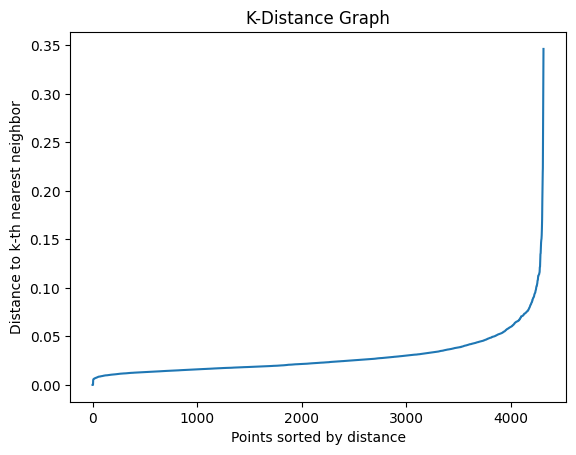

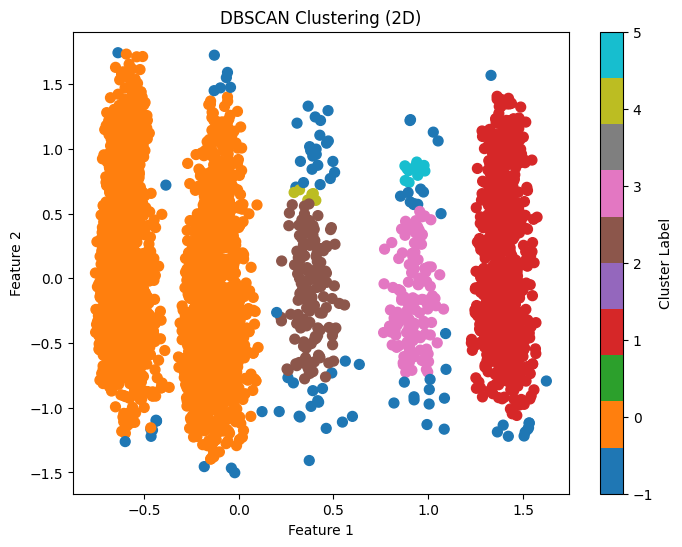

In [8]:

#DBSCAN, different code blocks to test each clustering algorithm separately
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan.fit(df_sample)
dbscan_labels = dbscan.labels_
 


# Using a k-distance graph to find the best epsilon value
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(df_sample)
distances, indices = nbrs.kneighbors(df_sample)
 
# Sorting distances
distances = np.sort(distances[:, k-1], axis=0)

# plotting K-distance graph
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.show()
 
# Creating scatter plot of clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=dbscan_labels, cmap='tab10', s=50)
plt.title("DBSCAN Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")
plt.show()
 

Task 3.3 - Birch

0.3081829894158771
1658.1280167964287


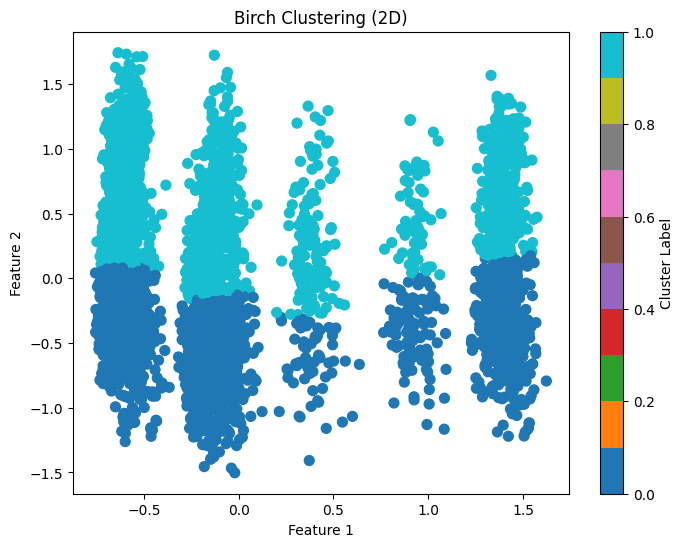

In [9]:

# BIRCH, different code blocks to test each clustering algorithm separately
birch = Birch(threshold=0.2, n_clusters=2, branching_factor=25)
birch.fit(df_sample)
birch_labels = birch.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=birch_labels, cmap='tab10', s=50)
plt.title("Birch Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")


# Printing scores for testing
print(sk.metrics.silhouette_score(X=df_sample, labels=birch_labels))
print(calinski_harabasz_score(df_sample, birch_labels))

# Findings: Creating 2 clusters creates visually the best clusters, when upping the n_clusters to 5 we see more horizontal clustering

===Task 4: Evaluation of clustering methods===

Goal: Be able to evaluate clustering methods using different evaluation measures and reason on their performance


Task 4.1 - Sillhouette score

We manually calculate the sillhoutte score for each of the clusterings. The score can be anywhere between -1 and 1, with higher scores indicating "stronger" sillhouettes.

In [11]:
# SILLHOUETTE SCORE

# We chose to use the eaclidean distance over the manhatten distance to calculate the sillhoutte score
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

def silhouette_score(labels, df_sample):
    
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    n_samples = len(df_sample)
    
    # Convert dataframe to numpy array for faster row-wise operations
    df_values = df_sample.values
    
    Si_total = 0
    
    for index in range(n_samples):
        
        current_cluster = labels[index]
        Ci = np.sum(labels == current_cluster)  # Count points in the same cluster

        own_clust_dist = 0

        # Calculate intra-cluster distance Ai
        for index2 in range(n_samples):
            if labels[index2] == current_cluster and index2 != index:
                dist = euclidean(df_values[index], df_values[index2])
                own_clust_dist += dist
        
        if Ci > 1:
            Ai = (1 / (Ci - 1)) * own_clust_dist  # Intra-cluster distance
        else:
            Ai = 0

        min_distance = float('inf')  # Initialize minimum distance as infinity

        # Calculate inter-cluster distance Bi
        for other_clust in unique_clusters:
            if other_clust != current_cluster:
                distance_sum = 0
                for index3 in range(n_samples):
                    if labels[index3] == other_clust:
                        distance_sum += euclidean(df_values[index], df_values[index3])
                average_dist = distance_sum / np.sum(labels == other_clust)
                
                if average_dist < min_distance:
                    min_distance = average_dist

        Bi = min_distance
        
        # Calculate silhouette score Si
        if Ci > 1 and Bi != 0 and Ai != 0:
            Si = (Bi - Ai) / max(Bi, Ai)
        else:
            Si = 0

        Si_total += Si

    # Return the average silhouette score
    return Si_total / n_samples

         
#Calculate the score for each clustering method
birch_sil_score = silhouette_score(birch_labels, df_sillhouette_sample)
print("Sillhouette score for birch clustering:", birch_sil_score)

dbscan_sil_score = silhouette_score(dbscan_labels, df_sillhouette_sample)
print("Sillhouette score for DBScan clustering:", dbscan_sil_score)

affinity_sil_score = silhouette_score(affinity_labels, df_sillhouette_sample)
print("Sillhouette score for affinity propagation clustering:", affinity_sil_score)



print("The highest score has the strongest clustering")

#Compare the scores and print the best scoring clustering method
dic1 = {birch_sil_score: "birch", dbscan_sil_score: "DBScan", affinity_sil_score: "affinity propagation"}
print("The best scoring algorithm is the", dic1[max(birch_sil_score, dbscan_sil_score, affinity_sil_score)], "clustering algorithm")

Sillhouette score for birch clustering: 0.0014422048250755674
Sillhouette score for DBScan clustering: -0.11448311331244268
Sillhouette score for affinity propagation clustering: 0.0
The highest score has the strongest clustering
The best scoring algorithm is the birch clustering algorithm


Task 4.2 - Davies Bouldin Score

this evaluation method calculates a score the provided clustering and dataset. A lower score implies better clustering, with a lowest possible score 0.

In [33]:

#Start of with calculating the score for each clustering method
birch_bouldin_score = davies_bouldin_score(df_sample, birch_labels)
dbscan_bouldin_score = davies_bouldin_score(df_sample, dbscan_labels)
affinity_bouldin_score = davies_bouldin_score(df_sample, affinity_labels)

print("Davies Bouldin score for birch clustering:", birch_bouldin_score)
print("Davies Bouldin score for DBScan clustering:", dbscan_bouldin_score)
print("Davies Bouldin score for affinity propagation clustering:", affinity_bouldin_score)
print("The lowest score is the best result")

#Compare the scores and print the best scoring clustering method
dic = {birch_bouldin_score: "birch", dbscan_bouldin_score: "DBScan" , affinity_bouldin_score: "affinity propagation"}
print("The best scoring algorithm is the", dic[min(birch_bouldin_score, dbscan_bouldin_score, affinity_bouldin_score)], "clustering algorithm")

Davies Bouldin score for birch clustering: 0.8292824930564336
Davies Bouldin score for DBScan clustering: 3.1776685835543423
Davies Bouldin score for affinity propagation clustering: 0.35061532241085513
The lowest score is the best result
The best scoring algorithm is the affinity propagation clustering algorithm


Task 4.3 - Calinski Harabasz Score

this evaluation method calculates a score the provided clustering and dataset. A higher score implies better clustering.

In [32]:

#Start of with calculating the score for each clustering method
birch_harabasz_score = calinski_harabasz_score(df_sample, birch_labels)
dbscan_harabasz_score = calinski_harabasz_score(df_sample, dbscan_labels)
affinity_harabasz_score = calinski_harabasz_score(df_sample, affinity_labels)

print("Calinski Harabasz score for birch clustering:", birch_harabasz_score)
print("Calinski Harabasz score for DBScan clustering:", dbscan_harabasz_score)
print("Calinski Harabasz score for affinity propagation clustering:", affinity_harabasz_score)
print("The highest score is the best result")

#Compare the scores and print the best scoring clustering method
dic1 = {birch_harabasz_score: "birch", dbscan_harabasz_score: "DBScan", affinity_harabasz_score: "affinity propagation"}
print("The best scoring algorithm is the", dic1[max(birch_harabasz_score, dbscan_harabasz_score, affinity_harabasz_score)], "clustering algorithm")

Calinski Harabasz score for birch clustering: 5627.185274537272
Calinski Harabasz score for DBScan clustering: 716.5046393561429
Calinski Harabasz score for affinity propagation clustering: 316.8548967586766
The highest score is the best result
The best scoring algorithm is the birch clustering algorithm


===Task 5: Manually implementing different distance functions and testing to see which performs best in DBSCAN clustering Algorithm===

In [52]:

# 5.1: Manual Euclidian Distance, square root of squared difference 
def manual_euclidean_distance(p1, p2):

    distance = 0.0
    
    for i in range(len(p1)):
        distance += (p1[i] - p2[i]) ** 2
    
    return distance ** 0.5



# 5.2: Manual Manhatten Distance
def manual_manhattan_distance(p1, p2):
    distance = 0.0
    
    for i in range(len(p1)):
        distance += abs(p1[i] - p2[i]) # Absolute distance between 2 points
    
    return distance


#5.3: Manual Cosine Similarity Distance Function
def cosine_similarity(A, B):

    dot_product = sum(a * b for a, b in zip(A, B))
    
    norm_A = math.sqrt(sum(a ** 2 for a in A))
    norm_B = math.sqrt(sum(b ** 2 for b in B))
    
    # No division by 0
    if norm_A == 0 or norm_B == 0:
        return 0.0
    
    return dot_product / (norm_A * norm_B)

# Take the cosine similarity and compute difference 
def manual_cosine_distance(A, B):
    return 1 - cosine_similarity(A, B)

We evaluate the different distance functions below using the Calinski Harabasz index. 
A higher score here means a better cluster, and the DBSCAN parameters have been optimized to attain the highest possible CH score.

In [ ]:

# 5.4: Evaluating DBSCAN with different distance functions

# Taking subset for speed, which currently is just our sample
df_subset = df_sample

# Performing DBSCAN with manually implemented euclidian distance
eucl_dbscan = DBSCAN(eps=0.2, min_samples=25, metric=manual_euclidean_distance)
fit_euclid_dbscan = eucl_dbscan.fit(df_subset)
eucl_labs = fit_euclid_dbscan.labels_


#DBSCAN with manually implemented Manhattan distance
man_dbscan = DBSCAN(eps=0.2, min_samples=15, metric=manual_manhattan_distance)
fit_manhattan_dbscan = man_dbscan.fit(df_subset)
man_labs = fit_manhattan_dbscan.labels_


#DBSCAN with Cosine Similarity
cos_dbscan = DBSCAN(eps=0.0008, min_samples=20, metric=manual_cosine_distance)
fit_cos_dbscan = cos_dbscan.fit(df_subset)
cos_labs = fit_cos_dbscan.labels_


# calculating the Calinski-Harabasz scores
calinski_euclidean = calinski_harabasz_score(df_subset, eucl_labs)
calinski_manhattan = calinski_harabasz_score(df_subset, man_labs)



# print the results
print(f"Calinski-Harabasz Index - Euclidean: {calinski_euclidean}")
print(f"Calinski-Harabasz Index - Manhattan: {calinski_manhattan}")


# Cosine similarity tends to have 0 clusters, therefore this block to prevent errors
if len(set(cos_labs)) > 1:
    calinski_cosine = calinski_harabasz_score(df_subset, cos_labs)
    print(f"Calinski-Harabasz Index - Cosine: {calinski_cosine}")
else:
    print("Not enough clusters")

Calinski-Harabasz Index - Euclidean: 2159.2539808775655
Calinski-Harabasz Index - Manhattan: 1485.3174994284743
Calinski-Harabasz Index - Cosine: 2225.509425226469


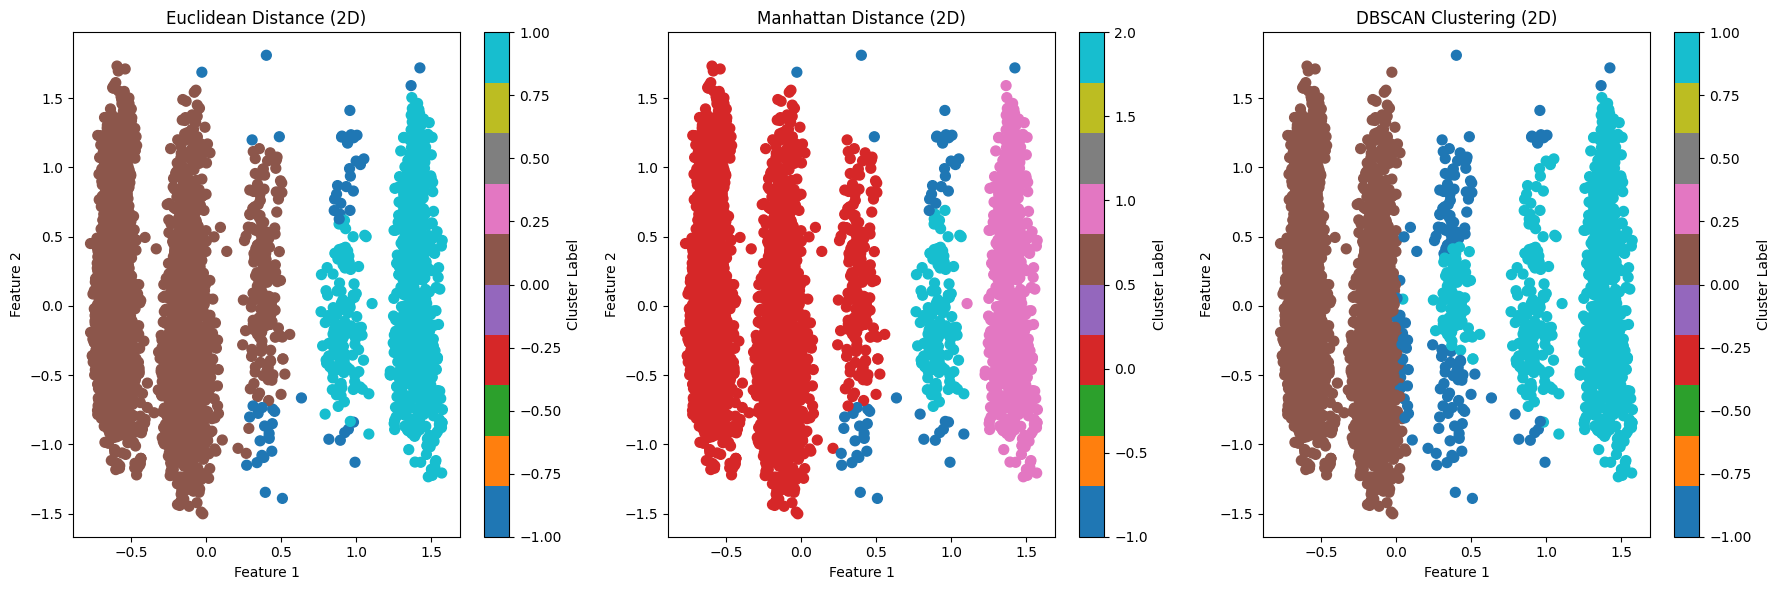

In [54]:

# Creating a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Euclidean distance
sc1 = axs[0].scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=eucl_labs, cmap='tab10', s=50)
axs[0].set_title("Euclidean Distance (2D)")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")
fig.colorbar(sc1, ax=axs[0], label="Cluster Label")

# Scatter plot for Manhattan distance
sc2 = axs[1].scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=man_labs, cmap='tab10', s=50)
axs[1].set_title("Manhattan Distance (2D)")
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Feature 2")
fig.colorbar(sc2, ax=axs[1], label="Cluster Label")

# Scatter plot for DBSCAN clustering
sc3 = axs[2].scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=cos_labs, cmap='tab10', s=50)
axs[2].set_title("DBSCAN Clustering (2D)")
axs[2].set_xlabel("Feature 1")
axs[2].set_ylabel("Feature 2")
fig.colorbar(sc3, ax=axs[2], label="Cluster Label")

# show plot
plt.tight_layout()
plt.show()
